# Simulating data

In [1]:
# Loading required packages
import bambi as bmb
import scipy as sp
import numpy as np
import arviz as az
import polars as pl
import plotnine as p9
import matplotlib.pyplot as plt

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1996)

One method for validating proposed models is to generate a known dataset
and then fit your model to the given dataset. If we observe difficulties
fitting the model we need to reconsider the parameterisation or the
priors.

## Experiment

Given that there are two strains we want characterise the amount of
protein each cell line produced. We have access to sets of reactors to
perform this experiment, and the protein concentrations will be measured
using mass spectroscopy that has a log-normal measurement model.

### Notes

-   Often we want to make statements about strains rather than reactors.
-   If we assume that the reactor to reactor variation is the same
    between strains then we are able to improve our fits using a
    heirarchical modelling approach called “partial pooling”,

In [42]:
# Generating the dataset
strain_growth_array = [0.4, 0.425, 0.5]
strain_growth_map = {
    strain: np.log(val)
    for strain, val in enumerate(strain_growth_array)
}
sigma_reactor_effect = 0.05
sigma_quant = 0.03
n_reactors = 2
n_replicates = 4
protein_measurements = { strain:
    [float(np.exp(np.log(strain_growth_array[strain]) + np.random.normal(0, 1)*sigma_reactor_effect)) for _ in range(n_reactors)]
                    for strain, _ in enumerate(strain_growth_array)
}
reactor_count = 0
raw_data = []
for strain, _ in enumerate(strain_growth_array):
    for reactor, _ in enumerate(protein_measurements[strain]):
        for replicate in range(n_replicates):
            raw_data.append(
            {
                "strain": strain,
                "reactor": reactor_count,
                "prot": np.log(protein_measurements[strain][reactor]) + np.random.normal(0,1)*sigma_quant,
            }
                )
        reactor_count+=1
data = pl.from_dicts(raw_data)
data

In [46]:
strain_growth_map

{0: np.float64(-0.916290731874155),
 1: np.float64(-0.8556661100577202),
 2: np.float64(-0.6931471805599453)}

# Confidence Interval

In [49]:
alpha = 0.05
summary_stats = data.group_by("strain").agg(
    mean = pl.mean("prot"),
    SEM = pl.std("prot") / pl.col("prot").count(),
    count = pl.col("prot").count(),
)
summary_stats = summary_stats.with_columns(
    (
        pl.col("mean") + 
        (pl.col("count") - 1).map_elements(lambda df: sp.stats.t.ppf(1 - alpha / 2, df), return_dtype=pl.Float64) * pl.col("SEM")
    ).alias("upp_ci"),
    (
        pl.col("mean") - 
        (pl.col("count") - 1).map_elements(lambda df: sp.stats.t.ppf(1 - alpha / 2, df), return_dtype=pl.Float64) * pl.col("SEM")
    ).alias("low_ci"),
    pl.col("strain").replace_strict(strain_growth_map).alias("true_protein")
)
summary_stats

In [6]:
sp.stats.ttest_ind(data.filter(pl.col("strain")==0)["prot"], data.filter(pl.col("strain")==1)["prot"], equal_var=True)

TtestResult(statistic=np.float64(-3.5517718345604115), pvalue=np.float64(0.003189683995315531), df=np.float64(14.0))

# Statistical model

The model we are trying to fit in this instance is as follows
$$\mu_{reactor} \sim LogNormal(\mu_{true, reactor}, \sigma_{quant})$$
$$\mu_{true, reactor} \sim LogNormal(\mu_{true, strain}, \sigma_{biological})$$

With priors $$\sigma_{quant} \sim log_normal(log(0.01), 0.1)$$
$$\sigma_{biological} \sim HalfNormal(0.03)$$

In [7]:
priors1 = {
    "strain": bmb.Prior("Normal", mu=-0.7, sigma=1),
    "sigma": bmb.Prior("LogNormal", mu=np.log(sigma_quant), sigma=0.2),       # measurement error
    "1|reactor_sigma": bmb.Prior("HalfNormal", sigma=sigma_reactor_effect),
}

model1 = bmb.Model(
    "prot ~ 0 + strain + (1|reactor)",
    data=data.to_pandas(),
    categorical=["strain", "reactor"],
    priors=priors1,
    noncentered=False
)
results1 = model1.fit(tune=2000, nuts_sampler_kwargs={"target_accept": 0.99}, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, strain, 1|reactor_sigma, 1|reactor]

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.

In [51]:
strain_growth_map


{0: np.float64(-0.916290731874155),
 1: np.float64(-0.8556661100577202),
 2: np.float64(-0.6931471805599453)}

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

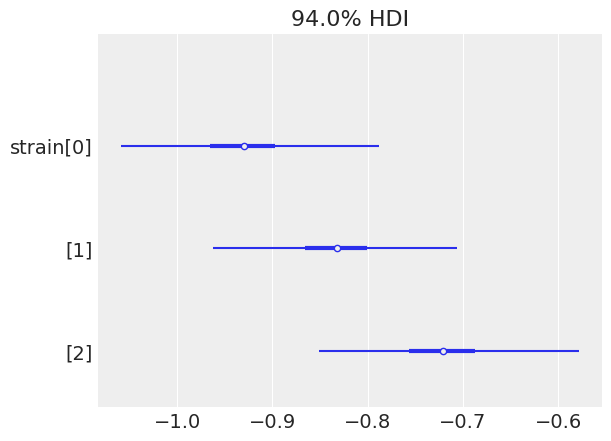

In [8]:
az.plot_forest(results1, var_names=["strain"], combined=True)

In [10]:
priors2 = {
    "strain": bmb.Prior("Normal", mu=-0.7, sigma=1),
    "sigma": bmb.Prior("LogNormal", mu=np.log((1/((1/sigma_quant)+(1/(sigma_reactor_effect))))), sigma=0.1),       # measurement error
}
model2 = bmb.Model(
    "prot ~ 0 + strain",
    data=data.to_pandas(),
    categorical=["strain", "reactor"],
    priors=priors2,
    noncentered=False
)
results2 = model2.fit(tune=2000, nuts_sampler_kwargs={"target_accept": 0.99}, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, strain]

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.

In [13]:
np.log(strain_growth_array)

array([-0.91629073, -0.85566611, -0.69314718])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

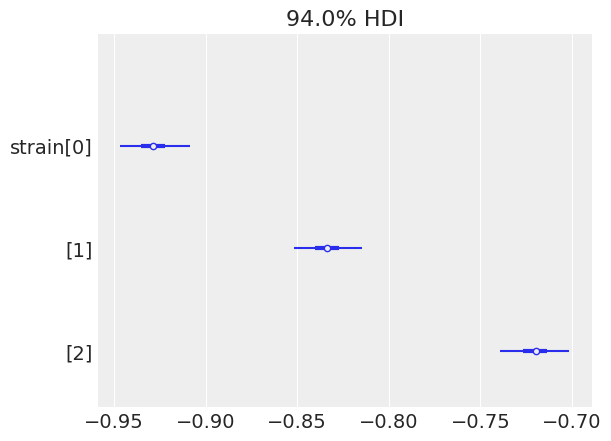

In [11]:
az.plot_forest(results2, var_names=["strain"], combined=True)

In [12]:
models_dict = {
    "model1": results1,
    "model2": results2,
}
df_compare = az.compare(models_dict)
df_compare

/home/nicholas/projects/bayesian_statistics_for_computational_biology/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:830: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.